# Climate exercise
This script downloads NCEI temperature data from XX and makes some figures 
to evaluate trends over time.

matthew.bitters@colorado.edu
10/1/2025

In [32]:
# Import libraries
import earthpy # Manage local data
import pandas as pd
import hvplot.pandas
import holoviews as hv
import numpy as np
# Advanced options on matplotlib/seaborn/pandas plots
import matplotlib.pyplot as plt
# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression

In [7]:
# url for Canberra airport - max temperature
can_url = ('https://www.ncei.noaa.gov/access/services/da'
'ta/v1?dataset=daily-summaries&dataTypes=TMAX&stations=ASN00070014&startDate=1939-03-01&endDate=2010-12-01&units=standard')
can_url

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TMAX&stations=ASN00070014&startDate=1939-03-01&endDate=2010-12-01&units=standard'

In [8]:
# Download the climate data
can_climate_df = pd.read_csv(
    can_url,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check that the download worked
can_climate_df.head()

,STATION,TMAX
DATE,,
1939-03-01,ASN00070014,75.0
1939-03-02,ASN00070014,74.0
1939-03-03,ASN00070014,74.0
1939-03-04,ASN00070014,75.0
1939-03-05,ASN00070014,NaN


In [9]:
# Rename max temp column (TMAX) to max_temp_f (deg f) 
can_climate_df = can_climate_df.rename(columns={
    'TMAX': 'max_temp_f',
})
can_climate_df.head()

,STATION,max_temp_f
DATE,,
1939-03-01,ASN00070014,75.0
1939-03-02,ASN00070014,74.0
1939-03-03,ASN00070014,74.0
1939-03-04,ASN00070014,75.0
1939-03-05,ASN00070014,NaN


In [10]:
# Convert temp_f to temp_c using a function
def convert_temp_f_to_c(max_temp_f):
    """Convert Fahrenheit temperature to Celcius"""
    return (max_temp_f-32) * 5/9

# Use function
can_climate_df['max_temp_c'] = (
    can_climate_df['max_temp_f'].apply(convert_temp_f_to_c))

# Look at df
can_climate_df

,STATION,max_temp_f,max_temp_c
DATE,,,
1939-03-01,ASN00070014,75.0,23.888889
1939-03-02,ASN00070014,74.0,23.333333
1939-03-03,ASN00070014,74.0,23.333333
1939-03-04,ASN00070014,75.0,23.888889
1939-03-05,ASN00070014,NaN,NaN
...,...,...,...
2010-11-27,ASN00070014,82.0,27.777778
2010-11-28,ASN00070014,66.0,18.888889
2010-11-29,ASN00070014,61.0,16.111111


In [11]:
# Save the climate data
can_climate_df.to_csv('canberra_climate_data')

<Axes: title={'center': 'Maximum temperature in Canberra, Australia (1939-2010)'}, xlabel='Year', ylabel='Temperature (degrees Celsius)'>

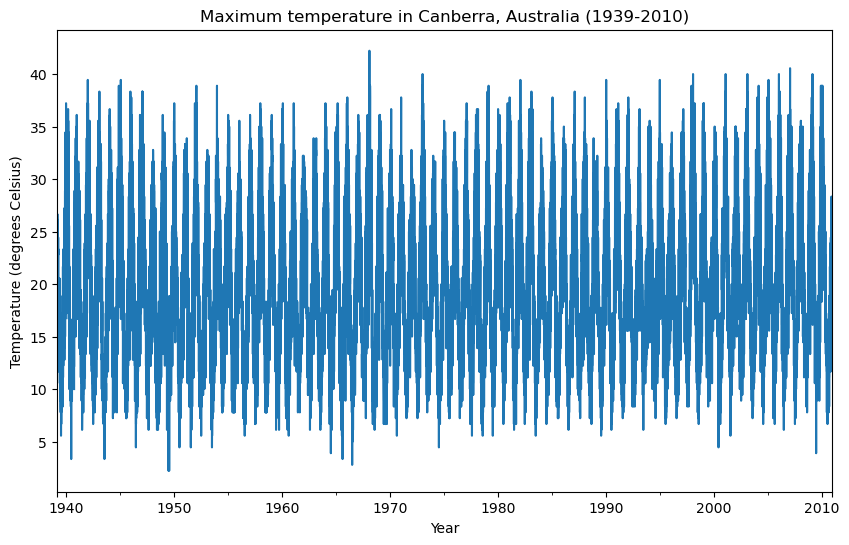

In [14]:
# Make a basic plot
can_climate_df.plot(
    y = 'max_temp_c',
    title = 'Maximum temperature in Canberra, Australia (1939-2010)',
    xlabel = 'Year',
    ylabel = 'Temperature (degrees Celsius)',
    figsize = (10,6),
    legend = False)

In [23]:
print(can_climate_df.columns)

Index(['STATION', 'max_temp_f', 'max_temp_c'], dtype='object')


In [25]:
# Summarize to annual average max temperature 
can_ann_df = (
can_climate_df[['max_temp_f', 'max_temp_c']]
.resample('YS')
.mean()
)


can_ann_df

,max_temp_f,max_temp_c
DATE,,
1939-01-01,63.222951,17.346084
1940-01-01,69.548209,20.860116
1941-01-01,67.443526,19.690848
1942-01-01,67.526027,19.736682
1943-01-01,64.336111,17.964506
...,...,...
2006-01-01,71.126027,21.736682
2007-01-01,70.161644,21.200913
2008-01-01,68.751366,20.417426


<Axes: title={'center': 'Mean annual max temperature in Canberra, Australia (1939-2010)'}, xlabel='Year', ylabel='Temperature (degrees Celsius)'>

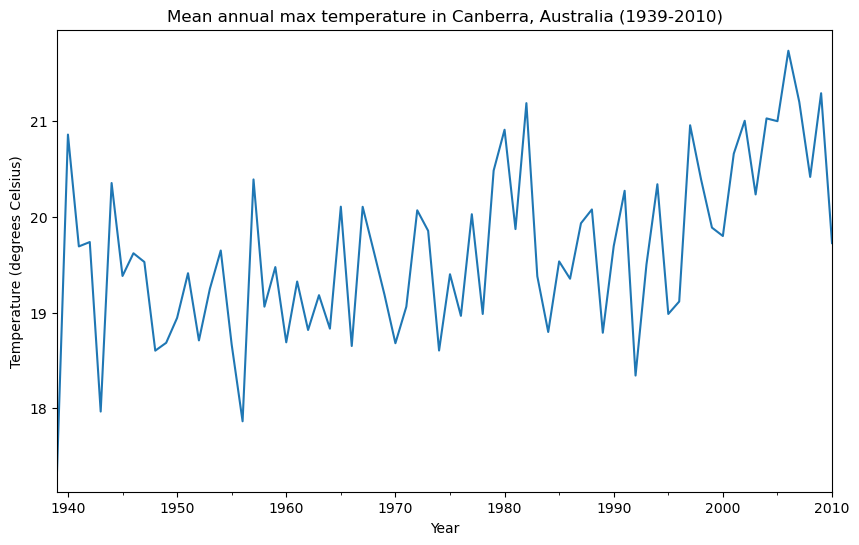

In [27]:
# Plot the annual data
can_ann_df.plot(
    y = 'max_temp_c',
    title = 'Mean annual max temperature in Canberra, Australia (1939-2010)',
    xlabel = 'Year',
    ylabel = 'Temperature (degrees Celsius)',
    figsize = (10,6),
    legend = False)

In [ ]:
# Plot the annual data interactively
inter_canberra_annual_climate_plot = can_ann_df.hvplot(
    y = 'max_temp_c',
    title = 'Mean annual max temperature in Canberra, Australia (1939-2010)',
    xlabel = 'Year',
    ylabel = 'Temperature (°C)',
    figsize = (10,6),
    legend = False)

inter_canberra_annual_climate_plot

:Curve   [DATE]   (max_temp_c)

In [31]:
# Save interactive annual plot
hv.save(inter_canberra_annual_climate_plot, 'inter_canberra_annual_climate_plot.html')

In [41]:
# Fit an OLS linear regression


# Reset index so DATE is a column again
can_ann_df = can_ann_df.reset_index()

# Extract year
can_ann_df["year"] = can_ann_df["DATE"].dt.year

# Drop rows with missing temp values
can_ann_df = can_ann_df.dropna(subset=["max_temp_c"])

# Define predictors (X) and response (y)
X = can_ann_df["year"].values.reshape(-1, 1)   # sklearn needs 2D array
y = can_ann_df["max_temp_c"].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Save coefficients
slope = model.coef_[0]
intercept = model.intercept_

# Print coefficients
print("Intercept (β0):", model.intercept_)
print("Slope (β1, °C per year):", model.coef_[0])

Intercept (β0): -23.865992429627404
Slope (β1, °C per year): 0.022028197784429066


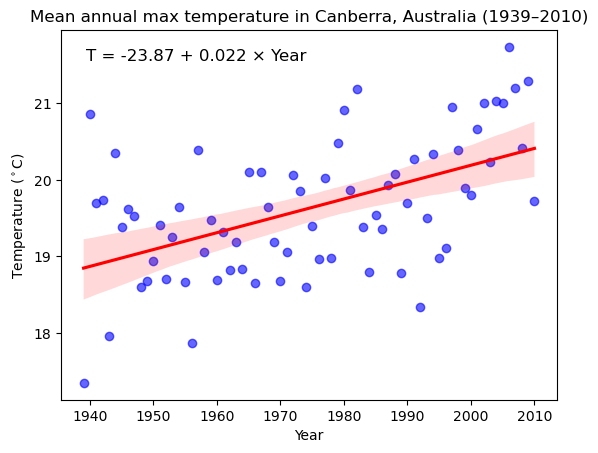

In [42]:
# Plot annual average max temperature with a trend line
ax = sns.regplot(
    data=can_ann_df,
    x="year", 
    y="max_temp_c",       
    scatter_kws={"alpha": 0.6, "color": "blue"},
    line_kws={"color": "red"}
)

# Set labels
ax.set(
    title='Mean annual max temperature in Canberra, Australia (1939–2010)',
    xlabel='Year',
    ylabel='Temperature ($^\circ$C)'
)

# Add regression equation as text in upper left corner
ax.text(
    0.05, 0.95,
    f"T = {intercept:.2f} + {slope:.3f} × Year",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

# Display the plot without extra text
plt.show()

In [44]:
# Save the figure
plt.savefig("canberra_annual_max_temp.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [43]:
# Predict trend values for first and last year
first_year = can_ann_df["year"].min()
last_year = can_ann_df["year"].max()

temp_first = model.predict([[first_year]])[0]
temp_last = model.predict([[last_year]])[0]

# Difference over the period
temp_change = temp_last - temp_first

print(f"Predicted temperature in {first_year}: {temp_first:.2f}°C")
print(f"Predicted temperature in {last_year}: {temp_last:.2f}°C")
print(f"Change over the period: {temp_change:.2f}°C")

# Predict temperature in 2050
year_2050 = 2050
temp_2050 = model.predict([[year_2050]])[0]

print(f"Predicted temperature in {year_2050}: {temp_2050:.2f}°F")

Predicted temperature in 1939: 18.85°C
Predicted temperature in 2010: 20.41°C
Change over the period: 1.56°C
Predicted temperature in 2050: 21.29°F
